In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def log_return(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [3]:
def log_volume(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [4]:
def bipower_variation(series, rollingWindow=5):
    '''
    Bipower Variation (BV) is the sum of the product of absolute time series returns
    :param column: price column
    :return: returns bivariate variation
    Barnhorf - Nielse & Shephard 2004 & 2006
    '''
    bv = (series.abs() *series.shift(1).abs()).dropna().rolling(rollingWindow).sum()
    
    return bv

In [5]:
def volatility_increments(series):
    theta = np.sqrt(series)
    Vt = (np.log(theta) - np.log(theta.shift(1))).dropna()
    return Vt

In [6]:
#################################################
# codes for implementing DFA-based analysis
# Exploring asymmetric multifractal cross-correlations of price-volatility and asymmetric volatility dynamics in cryptocurrency markets
#################################################
import numpy as np
import math
###########################################
# MF-ADCCA (includes DFA, DCCA, A-DFA, A-DCCA, MFDFA, MFDCCA, A-MFDFA)
##########################################

import numpy as np

def dcca(x, y, S, m, Q, trend_base=None, skip_agg=False, asymmetry_base='index'):
    """
    Calculate generalized Hurst Exponenet by Multi Fractal Detrended Cross-correlation Analysis.
    Args:
        x(array(float))  : Target time series data.
        y(array(float))  : Target time series data.
        S(array(int))    : Intervals which divides culmative sum time series. Needs to be a positive integer.
        m(int)           : Degree of polynomial fit for each divided segment. Generally, m=2 is recommended.
        Q(array(int))    : fluctuation q-th order.
        trend_base       : designated time series used for defining asymmetric trends.
        skip_agg(bool)   : Whether to use cumsum for profile. If series is stationary (ex. log-returns), then "False". If non-stationary (ex. level data), then "True".
                           It's not needed.
        asymmetry_base  : Which criterion used for defining asymmetric trends.
    Returns:
        array(float)     : Return generalized Hurst exponent (in np.array) of each Q-th order.
    """
    N = len(x)
    assert len(y) == N, '{} segments'.format(len(y))
    if skip_agg:
        X = np.copy(x)
        Y = np.copy(y)
    else:
        X = np.cumsum(x - np.mean(x))
        Y = np.cumsum(y - np.mean(y))

    def Fvs2(v, s, reverse=False):
        """
        (Root Mean Square) ** 2
        F(s, v)
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment_x = X[N - (v-Ns)*s:N - (v-Ns)*s+s]
            segment_y = Y[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment_x = X[(v-1)*s:v*s]
            segment_y = Y[(v-1)*s:v*s]
        coef_x = np.polyfit(ax, segment_x, m)
        coef_y = np.polyfit(ax, segment_y, m)
        fitting_x = np.polyval(coef_x, ax)
        fitting_y = np.polyval(coef_y, ax)
        return np.mean(np.abs(segment_x - fitting_x)*np.abs(segment_y - fitting_y)) # DCCA for x and y

    if asymmetry_base == 'index':
        x_alt = np.exp(np.cumsum(x)) # index-based
    elif asymmetry_base == 'return':
        x_alt = np.copy(x) # return-based
    elif asymmetry_base == 'optional':
        assert type(trend_base) == np.ndarray, 'trend_base is None. designate trend_base.'
        x_alt = np.copy(trend_base) # only for optional. Any series is possible, but designate trend_base.
    else:
        print('not available: index or return or optional only\nPlease choose either and try again')

    def asym_trend(v, s, reverse=False):
        """
        Detecting trend in some data series H
        L_H(x)=a_H+b_H x
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment = x_alt[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment = x_alt[(v-1)*s:v*s]
        coef = np.polyfit(ax, segment, 1) # m=1, y=ax+b (a,b)
        return coef[0] # represents a in y=ax+b

    Fhq = np.zeros(len(Q))
    Fhq_plus = np.zeros(len(Q))
    Fhq_minus = np.zeros(len(Q))
    
    for i, q in enumerate(Q):
        Fqs = np.zeros(len(S))
        Fqs_plus = np.zeros(len(S))
        Fqs_minus = np.zeros(len(S))

        for j, s in enumerate(S):
            Ns = int(N//s)
            segs = np.array([
                [Fvs2(v, s) for v in range(1, Ns + 1)],
                [Fvs2(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(segs) == 2 * Ns, '{} segments'.format(len(segs))

            trend_segs = np.array([
                [asym_trend(v, s) for v in range(1, Ns + 1)],
                [asym_trend(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(trend_segs) == 2 * Ns, '{} segments'.format(len(trend_segs))

            M_plus = np.sum((1+np.sign(trend_segs))/2)
            M_minus = np.sum((1-np.sign(trend_segs))/2)

            # calculate qth fluctuation function
            if q == 0:
                # asymmetric version
                Fqs_plus[j] = np.exp((np.sum(((1+np.sign(trend_segs))/2)*np.log(segs))/M_plus)/2)
                Fqs_minus[j] = np.exp((np.sum(((1-np.sign(trend_segs))/2)*np.log(segs))/M_minus)/2)
                # overall
                Fqs[j] = np.exp(np.mean(np.log(segs))/2)
            else:
                # asymmetric version
                Fqs_plus[j] = (np.sum(((1+np.sign(trend_segs))/2)*(segs ** (q/2))) /M_plus)**(1/q)
                Fqs_minus[j] = (np.sum(((1-np.sign(trend_segs))/2)*(segs ** (q/2)))/M_minus)**(1/q)
                # overall version
                Fqs[j] = np.mean(segs ** (q/2)) ** (1/q)

        coef_plus = np.polyfit(np.log(S), np.log(Fqs_plus), 1)
        coef_minus = np.polyfit(np.log(S), np.log(Fqs_minus), 1)
        coef = np.polyfit(np.log(S), np.log(Fqs), 1)
        Fhq_plus[i] = coef_plus[0]
        Fhq_minus[i] = coef_minus[0]
        Fhq[i] = coef[0]

    # 1~2: estimates for overall trend, 4~5: estimates for positive trend, 7~8: estimates for negative trend
    # S: scales, Fqs: fluctuation functions, Fhq: generalized hurst exponent
    return S, Fqs, Fhq, S, Fqs_plus, Fhq_plus, S, Fqs_minus, Fhq_minus

def basic_dcca(x, y, Q, m=2, trend_base=None, skip_agg=False, observations=100, asymmetry_base='index'):
    """
    polynominal fitting is set to m = 2 at default
    """
    N = len(x)
    s_min = max(20, int(np.floor(N/100)))
    s_max = min(20*s_min, int(np.floor(N/10)))
    s_inc = (s_max - s_min) / (observations-1)
    S = [s_min + int(np.floor(i*s_inc)) for i in range(0, observations)]
    return dcca(x, y, S=S, m=m, Q=Q, trend_base=trend_base, skip_agg=skip_agg, asymmetry_base=asymmetry_base)

def nonlinear_detrend(segment, degree=2):
    """
    Nonlinear detrending using local polynomial regression.
    Args:
        segment (np.array): Segment of the time series.
        degree (int): Degree of the polynomial regression (e.g., 2 for quadratic).
    Returns:
        np.array: Detrended segment.
    """
    n = len(segment)
    x = np.arange(n)
    
    # Fit a polynomial regression
    coefficients = np.polyfit(x, segment, degree)
    
    # Calculate the trend using the polynomial coefficients
    trend = np.polyval(coefficients, x)
    
    # Remove the trend from the segment
    detrended_segment = segment - trend
    
    return detrended_segment

def MFADCCA_Hurst(X, Y, T=252, step=1, Q=np.array([2]), trend_base=None, skip_agg=False, observations=100, asymmetry_base='return'):
    X = np.array(X)
    nX = X.shape[0]
    hurst = np.zeros(nX-T+1)
    hurst_plus = np.zeros(nX-T+1)
    hurst_minus = np.zeros(nX-T+1)
    
    for i in range(0, nX-T+1, step):
        XX = X[i:i+T]
        YY = Y[i:i+T]
        
        # Apply nonlinear detrending to the segments
        XX_detrended = nonlinear_detrend(XX)
        YY_detrended = nonlinear_detrend(YY)
        
        MFADCCA_Hurst = basic_dcca(XX_detrended, YY_detrended, Q=Q, trend_base=trend_base, skip_agg=skip_agg, observations=observations, asymmetry_base=asymmetry_base)
        hurst[i] = MFADCCA_Hurst[2]
        hurst_plus[i] = MFADCCA_Hurst[5]
        hurst_minus[i] = MFADCCA_Hurst[8]
    
    return hurst, hurst_plus, hurst_minus



In [7]:
# read data_set and split them
dataset = pd.read_csv(r"./Datasets/GDAXI/GDAXI_QPL.csv")
df = dataset.reset_index(drop=True)
df = df.head(2515)

Close = df['Close']
Volume = df['vol']
# compute Log return and bipower variation for MFADCCA
LogReturn = log_return(Close)         # X
Bv = bipower_variation(LogReturn)     # Y
Vt = volatility_increments(Bv)
vol =  log_volume(Volume) 

Q = np.array([2])

df['log_returns'] = LogReturn         # add to df
df['volatility_increments'] = Vt
df['log_volumes'] = vol

In [8]:
data = df.dropna(axis=0, how='any')

r = data["log_returns"]
v = data["volatility_increments"]
vol = data['log_volumes']

data

Unnamed: 0        Date      Open      High       Low     Close  \
7            7.0   2012/1/11   6148.45   6181.61   6106.03   6152.34   
8            8.0   2012/1/12   6160.09   6256.95   6148.85   6179.21   
9            9.0   2012/1/13   6242.49   6245.38   6063.66   6143.08   
10          10.0   2012/1/16   6120.40   6232.21   6104.11   6220.01   
11          11.0   2012/1/17   6301.91   6343.04   6270.97   6332.93   
...          ...         ...       ...       ...       ...       ...   
1513      1513.0  2017/12/19  13314.73  13338.91  13213.19  13215.79   
1514      1514.0  2017/12/20  13244.27  13252.67  13026.11  13069.17   
1515      1515.0  2017/12/21  13065.79  13137.71  13013.63  13109.74   
1516      1516.0  2017/12/22  13076.76  13108.56  13059.87  13072.79   
1517      1517.0  2017/12/27  13070.19  13128.74  13020.43  13070.02   

             QPLp1         QPLp2         QPLp3         QPLp4  ...  \
7      6163.106330   6197.413882   6239.875918   6287.500268  ...   
8      6174.774077   6209.146578   6251.689002   6299.403512  ...   
9      6257.370498   6292.202780   6335.314270   6383.667030  ...   
10     6134.989466   6169.140502   6211.408822   6258.815903  ...   
11     6316.932140   6352.095978   6395.617830   6444.430842  ...   
...            ...           ...           ...           ...  ...   
1513  13346.468910  13420.763370  13512.716710  13615.849270  ...   
1514  13275.840950  13349.742250  13441.208990  13543.795780  ...   
1515  13096.935500  13169.840910  13260.075040  13361.279370  ...   
1516  13107.931650  13180.898270  13271.208160  13372.497460  ...   
1517  13101.345990  13174.275950  13264.540470  13365.778880  ...   

            QPLn16        QPLn17        QPLn18        QPLn19        QPLn20  \
7      5335.966663   5276.799181   5217.814709   5159.085510   5100.674930   
8      5346.068502   5286.789007   5227.692867   5168.852485   5110.331324   
9      5417.579802   5357.507359   5297.620724   5237.993267   5178.689302   
10     5311.623314   5252.725762   5194.010384   5135.549115   5077.405011   
11     5469.147781   5408.503530   5348.046856   5287.851827   5227.983369   
...            ...           ...           ...           ...           ...   
1513  11555.262770  11427.133080  11299.399690  11172.219110  11045.728520   
1514  11494.113670  11366.662020  11239.604590  11113.097030  10987.275810   
1515  11339.218810  11213.484700  11088.139490  10963.336750  10839.211100   
1516  11348.739180  11222.899510  11097.449060  10972.541540  10848.311670   
1517  11343.037370  11217.260920  11091.873500  10967.028740  10842.861280   

            QPLn21     vol  log_returns  volatility_increments  log_volumes  
7      5042.638459  166.80    -0.001728              -0.140389    -0.027263  
8      5052.184981  205.75     0.004358              -0.027752     0.209866  
9      5119.765170  213.91    -0.005864               0.017547     0.038894  
10     5019.633310  108.07     0.012445               0.052480    -0.682776  
11     5168.498359  167.12     0.017991               0.092328     0.435933  
...            ...     ...          ...                    ...          ...  
1513  10920.048070   76.17    -0.007276               0.346642    -0.237197  
1514  10862.260450   82.31    -0.011156               0.128230     0.077525  
1515  10715.880450   72.54     0.003099               0.027422    -0.126354  
1516  10724.877470   54.51    -0.002822              -0.005579    -0.285754  
1517  10719.489100   46.06    -0.000212              -0.081053    -0.168439  

[1509 rows x 52 columns]

In [9]:
hurst, hurst_plus, hurst_minus = MFADCCA_Hurst(r, vol, T=256, step=1, Q=Q, trend_base=None, skip_agg=False, observations=100, asymmetry_base='return')

In [10]:
hurst.shape

(1254,)

In [11]:
data['hurst'] = pd.DataFrame(np.array([0] * 1254))
data['hurstp'] = pd.DataFrame(np.array([0] * 1254))
data['hurstm'] = pd.DataFrame(np.array([0] * 1254))

data = data.tail(1254)

data['hurst'] = hurst
data['hurstp'] = hurst_plus
data['hurstm'] = hurst_minus
data = data.reset_index(drop = True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_36280\2542206896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurst'] = pd.DataFrame(np.array([0] * 1254))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_36280\2542206896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurstp'] = pd.DataFrame(np.array([0] * 1254))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_36280\2542206896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [12]:
data.to_csv(r'./Datasets/GDAXI/GDAXI_nlMFADCCA.csv')

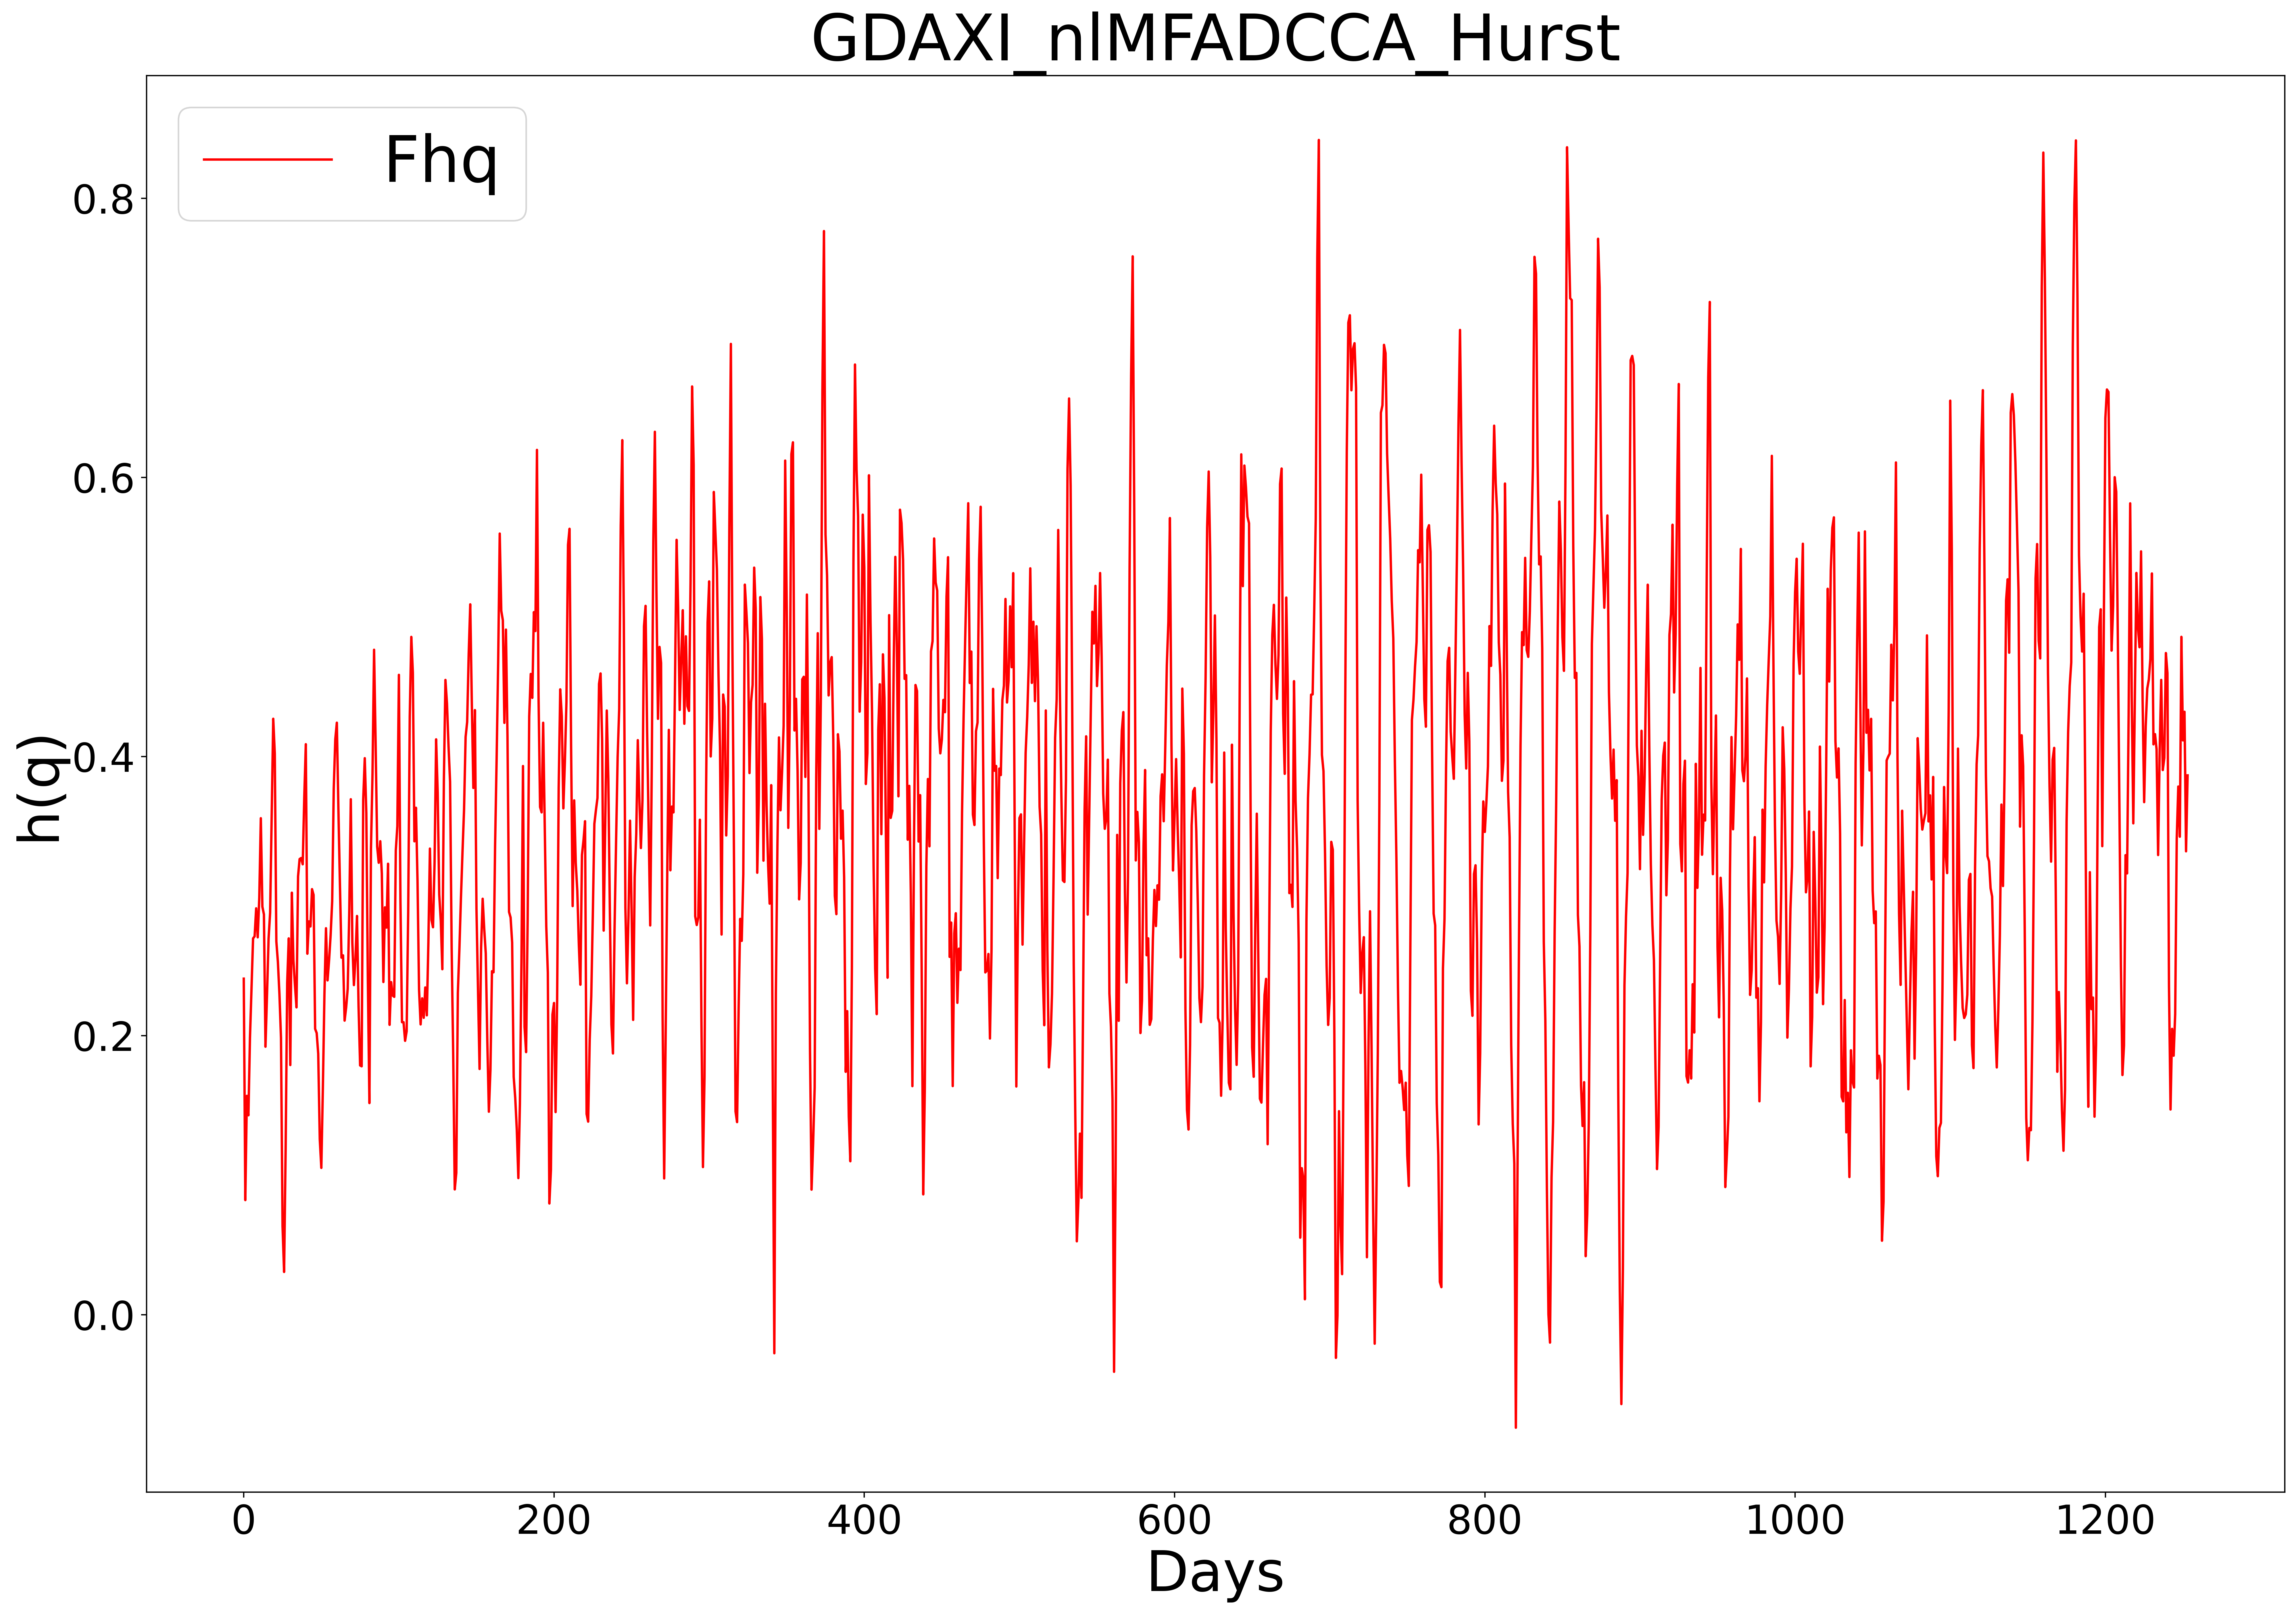

In [13]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst,color='r')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('GDAXI_nlMFADCCA_Hurst', fontsize=40)
plt.legend(['Fhq'],fontsize=40)
plt.savefig('./pic/GDAXI_pic/GDAXI_nlMFADCCA_hurst.png')
plt.show()

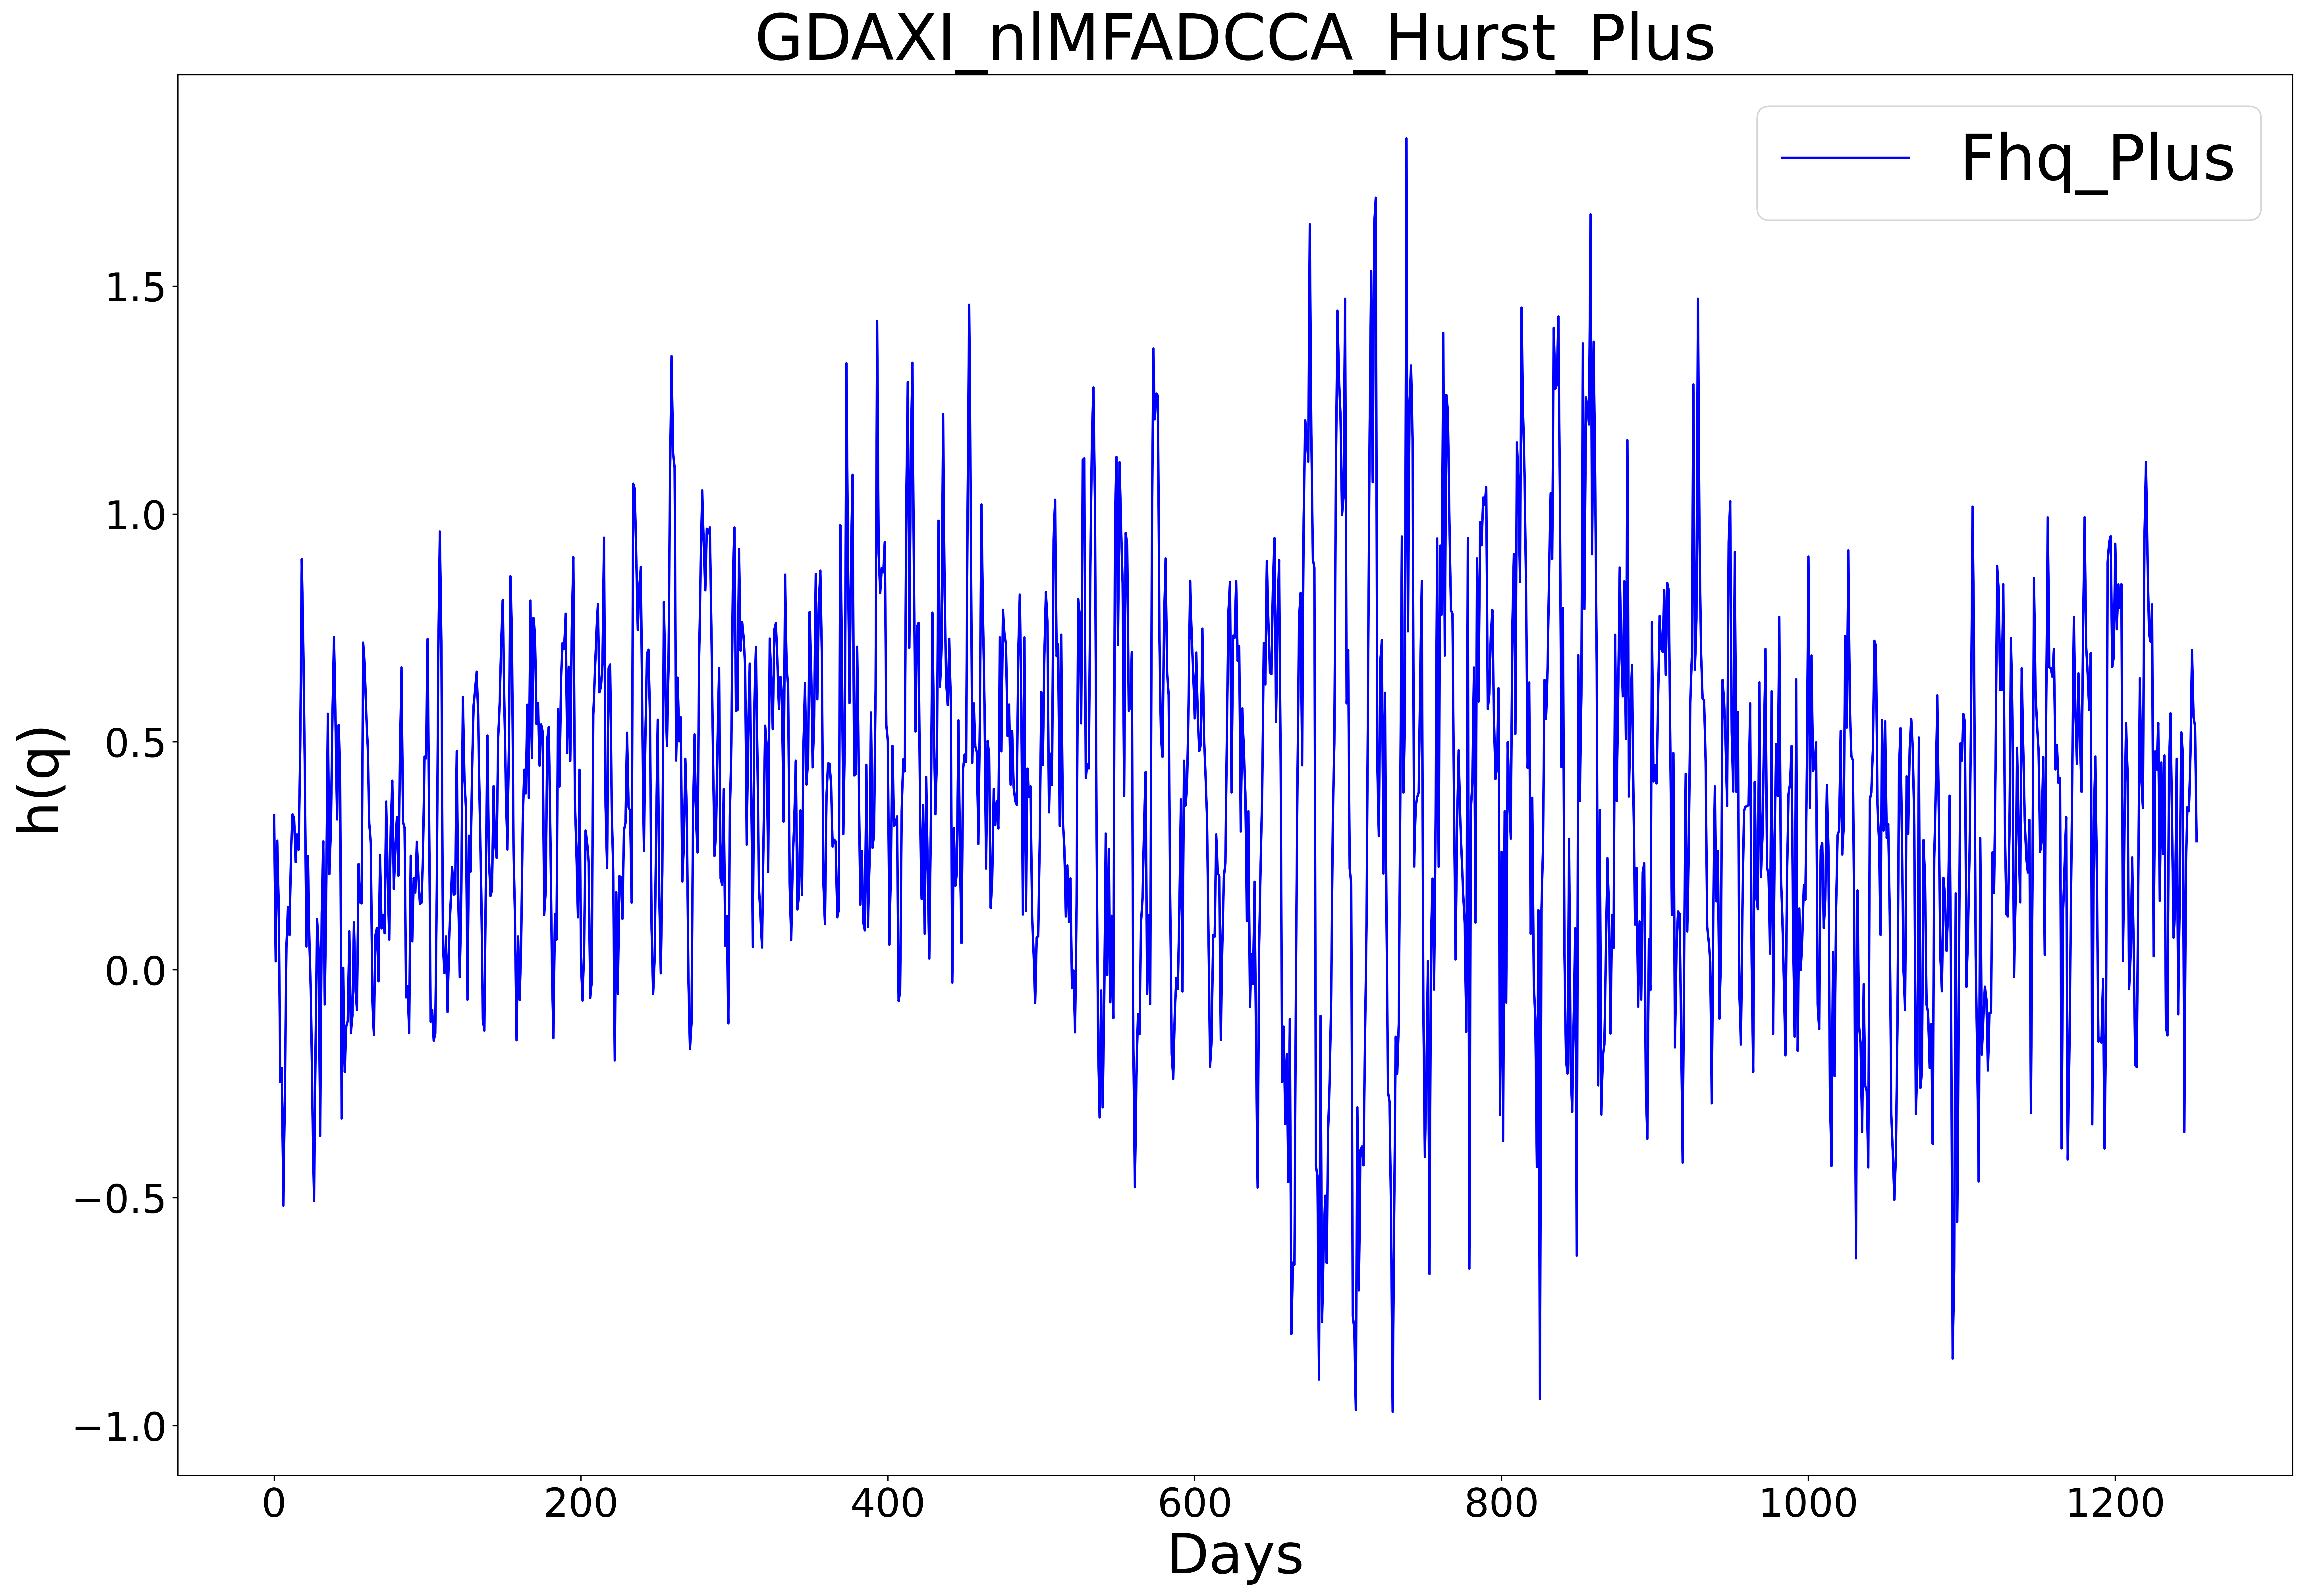

In [14]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_plus,color='b')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('GDAXI_nlMFADCCA_Hurst_Plus', fontsize=40)
plt.legend(['Fhq_Plus'],fontsize=40)
plt.savefig('./pic/GDAXI_pic/GDAXI_nlMFADCCA_hurstplus.png')
plt.show()

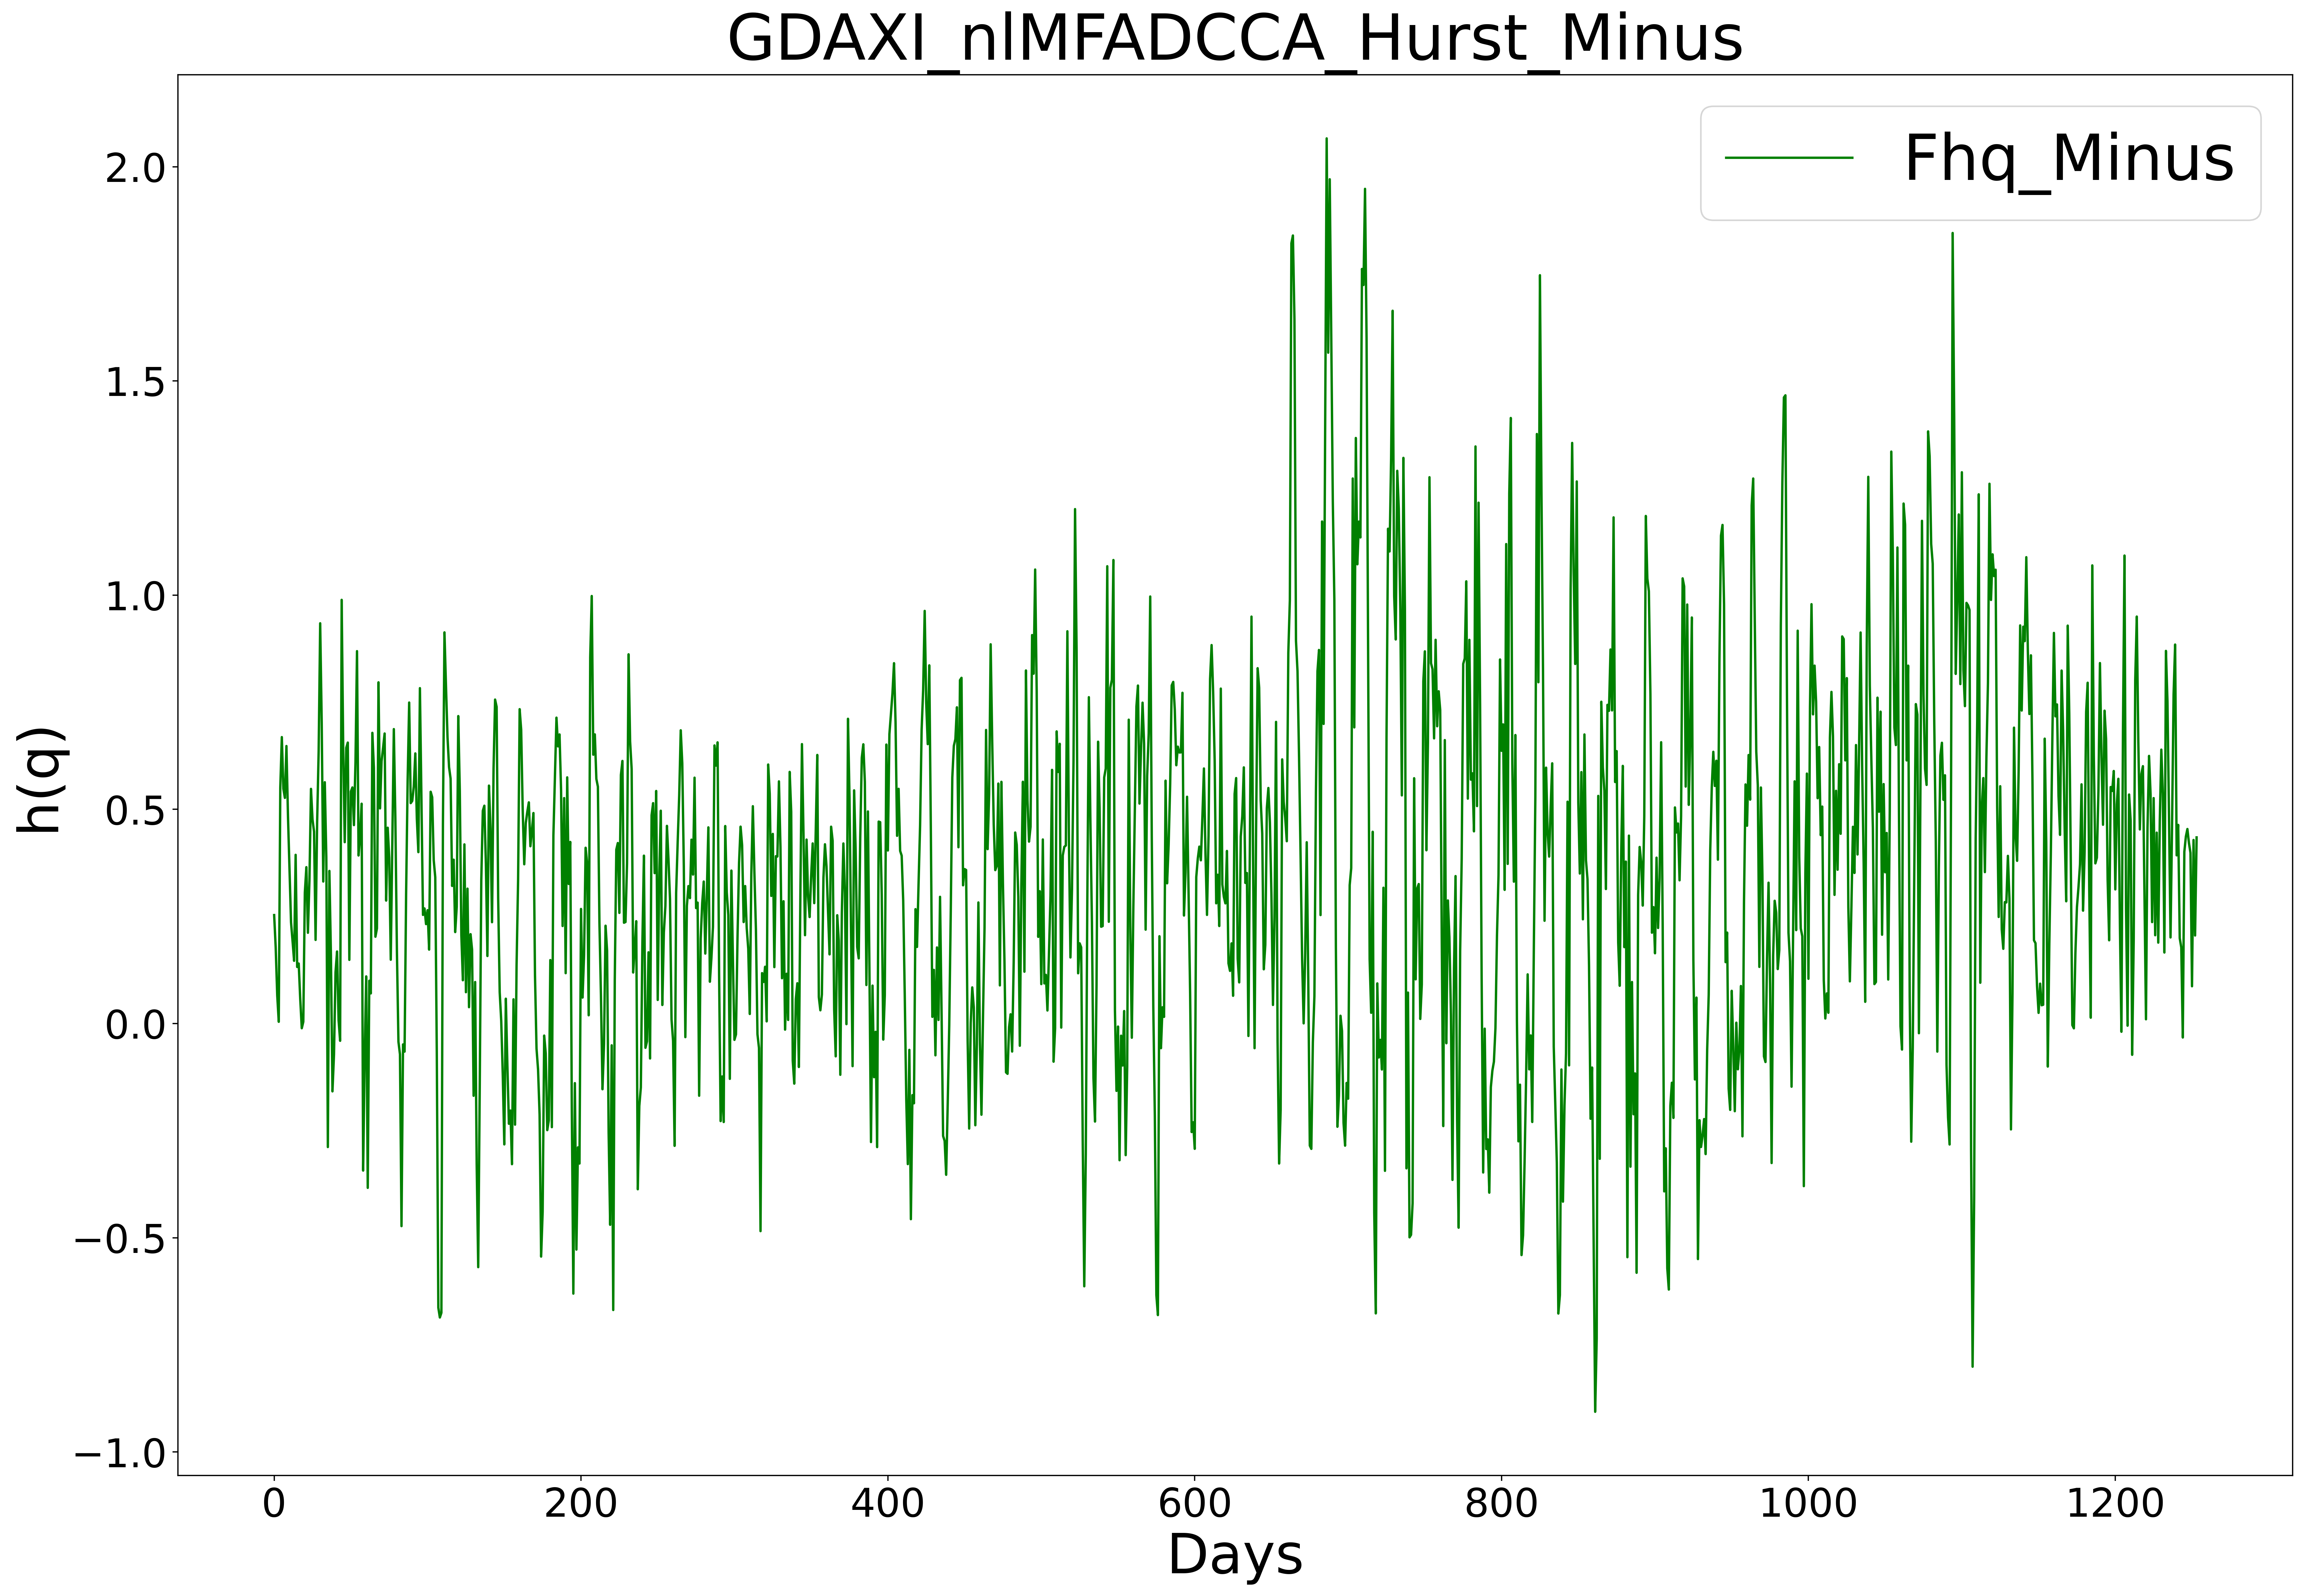

In [15]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_minus,color='g')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('GDAXI_nlMFADCCA_Hurst_Minus', fontsize=40)
plt.legend(['Fhq_Minus'],fontsize=40)
plt.savefig('./pic/GDAXI_pic/GDAXI_nlMFADCCA_hurstminus.png')
plt.show()